## Synthetic Data

In [510]:
import numpy as np
import pandas as pd
import random
import math

In [511]:
# Load data
mat = np.load("Amean_Alpha.npy") 
f = np.load("freq_Alpha.npy") 
counts_total = np.load("totcounts_Alpha.npy")
counts = np.load("counts_Alpha.npy")

# print("Shape of mat: ", np.shape(mat))
# print("Shape of f: ", np.shape(f))
# print("Shape of counts_total:", np.shape(counts_total))

N = counts_total[:,13] * 1000 #Selecting total sequences starting at last time step (I included the x100 to suppress noise)
X = f[:,1,13] #Selecting allele 0 at last time step
X_counts = counts[:,1,13] * 1000

In [512]:
def simple_noise(freq, total_seq = N, demes = 9): 
    ''' 
    Adding noise to frequncy by sampling from binomial distrubution. 
    This approach uses a fixed number of sequences in each trial (given from initial data).
    We only model the genetic drift and neglect 
    '''
    x_N = []
    for i in range(len(freq)):
        x_i = np.random.binomial(total_seq[i], freq[i], size=None) / total_seq[i] #For each deme i
        x_N.append(x_i) #assembling the x vector with noise modification
    return x_N
    

In [513]:
def deme_reduction (num_demes, matrix): 
    mat = np.array([x[:num_demes]/np.sum(x[:num_demes]) for x in matrix[:num_demes]])
    return mat

In [514]:
def data_saver(time_steps, path):
    '''
    Saves data to CSV in whatever format
    
    '''
    # Generate index values as a separate column
    index_column = list(range(len(time_steps)))
    
    #time_steps is a list of lists, where each inner list has 9 elements (for 9 regions)
    column_names = [f"Region_{i}" for i in range(len(time_steps[0]))]
    
    # Convert results to a DataFrame
    time_steps_df = pd.DataFrame(time_steps, columns=column_names)
    
    # Set a synthetic datetime index with weekly frequency starting from a specific date (This is necessary for the transformer input)
    date_index = pd.date_range(start='2023-01-01', periods=len(time_steps_df), freq='W')
    
    # Insert the date index as the first column
    time_steps_df.insert(0, "Date", date_index)
    
    # Save the DataFrame to CSV without the default DataFrame index
    time_steps_df.to_csv(path, index=False)

In [515]:
def dynamics(matrix, num_steps, initial_freq, total_counts):
    time_steps = []
    
    step = initial_freq
    
    for s in range(num_steps):
        step = matrix.dot(step) 
        step = simple_noise(step, total_counts)
        time_steps.append(step) 
    return time_steps

In [516]:
def generate_samples(matrix, data, total_counts, NSP = 10000):
    
    final_prob = np.transpose(matrix.dot(np.transpose(data[-1:])))
    samps = [np.random.binomial(n = n, p = i, size = NSP) / n for n,i in zip(total_counts,final_prob.flatten())]
    
    return samps

In [517]:
def convert_total_counts(target, total_counts = N):
    num_demes = len(target)
    new_total_counts = np.zeros(len(target))
    
    for i in range(num_demes):
        for j in target[i]:
            new_total_counts[i] += total_counts[j]
    return new_total_counts

In [518]:
def initial_frequency(counts, target, total_counts = N):
    num_demes = len(target)
    new_freq = []
                    
    for i in range(num_demes):
        temp = 0
        for j in target[i]:
            temp += counts[j] / total_counts[i]
        new_freq.append(temp)
    return new_freq
        

In [519]:
# Reconfiguring initial conditions for the modified demes
combine = [[0,1,2], [3,4,5], [6,7,8]]
# combine = [[x] for x in range(9)]
total = convert_total_counts(combine, N)
freq = initial_frequency(X_counts, combine, total)

[2803000. 1518000.  935000.]
[np.float64(0.01569746699964324), np.float64(0.04216073781291173), np.float64(0.07486631016042782)]


In [520]:
matrix = deme_reduction(3, mat)
series = dynamics(matrix, 200, freq, total)
samples = generate_samples(matrix, series, total)

[np.float64(0.03695861576881912), np.float64(0.044879446640316206), np.float64(0.04191657754010695)]
[np.float64(0.01569746699964324), np.float64(0.04216073781291173), np.float64(0.07486631016042782)]


In [521]:
data_saver(series, 'multivariate_MOIRAI/3deme.csv')
data_saver(series, 'univariate_MOIRAI/3deme.csv')
#print(np.shape(samps_mod))

### MOIRAI Predictions

In [682]:
import os
import subprocess
import json
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.stats import entropy

In [683]:
# Base paths for the folders
base_path = os.getcwd()

univariate_path = os.path.join(base_path, "Univariate_MOIRAI")
uni_predictions = os.path.join(base_path, "Univariate_MOIRAI/forecast.npy")

multivariate_path = os.path.join(base_path, "Multivariate_MOIRAI")
multi_predictions = os.path.join(base_path, "Multivariate_MOIRAI/forecast.npy")

# Unified configuration file
config_path = os.path.join(base_path, "config.json")

# Docker images
docker_images = {
    "multivariate": "multivariate_moirai_image",
    "univariate": "univariate_moirai_image",
}

In [684]:
# Definitions for managing docker

def build_docker(container_type):
    """Build the Docker image for the specified container type.
    
    Parameters:
    container_type (str): The type of container to build ("multivariate" or "univariate").
    
    Returns:
    None
    
    Raises:
    ValueError: If the container_type is invalid.
    """
    if container_type not in ["multivariate", "univariate"]:
        raise ValueError(f"Invalid container type: {container_type}")
    
    folder_path = multivariate_path if container_type == "multivariate" else univariate_path
    docker_image = docker_images[container_type]
    
    print(f"Building Docker image for {container_type}...")
    
    try:
        subprocess.run(
            ["docker", "build", "-t", docker_image, folder_path],
            check=True
        )
    except subprocess.CalledProcessError as e:
        print(f"Error building {container_type} image: {e}")
        raise


def run_multiple(docker_image):
    """Load configurations and execute multiple Docker runs.
    
    Parameters:
    docker_image (str): The Docker image to use for the runs.
    
    Returns:
    None
    """
    with open("config.json", "r") as f:
        config = json.load(f)

    for i, run_config in enumerate(config["runs"]):
        print(f"Running configuration {i + 1}/{len(config['runs'])}: {run_config}")
        run_docker_with_params(run_config, docker_image, f"run_{i + 1}")

def run_docker_with_params(config, docker_image, run_name):
    """Run a Docker container with specific parameters.
    
    Parameters:
    config (dict): The configuration for the Docker run.
    docker_image (str): The Docker image to use.
    run_name (str): The name of the run.
    
    Returns:
    None
    """
    # Save temp config file for this run
    temp_config_path = os.path.join("/tmp", f"temp_config_{run_name}.json")
    with open(temp_config_path, "w") as temp_config:
        json.dump(config, temp_config)

    folder_path = multivariate_path if docker_image == docker_images["multivariate"] else univariate_path

    # Run Docker container with mounted temp config
    subprocess.run(
        [
            "docker", "run", 
            "-v", f"{temp_config_path}:/app/config.json",  # Mount temp config
            "-v", f"{folder_path}:/app",  # Mount repository
            docker_image
        ],
        check=True
    )


In [685]:
build_docker("multivariate")

Building Docker image for multivariate...


#0 building with "desktop-linux" instance using docker driver

#1 [internal] load build definition from Dockerfile
#1 transferring dockerfile: 1.11kB done
#1 DONE 0.0s

#2 [internal] load metadata for docker.io/library/python:3.10-slim
#2 ...

#3 [auth] library/python:pull token for registry-1.docker.io
#3 DONE 0.0s

#2 [internal] load metadata for docker.io/library/python:3.10-slim
#2 DONE 0.9s

#4 [internal] load .dockerignore
#4 transferring context: 2B done
#4 DONE 0.0s

#5 [ 1/11] FROM docker.io/library/python:3.10-slim@sha256:bdc6c5b8f725df8b009b32da65cbf46bfd24d1c86dce2e6169452c193ad660b4
#5 resolve docker.io/library/python:3.10-slim@sha256:bdc6c5b8f725df8b009b32da65cbf46bfd24d1c86dce2e6169452c193ad660b4 0.0s done
#5 DONE 0.0s

#6 [internal] load build context
#6 transferring context: 38.34kB 0.0s done
#6 DONE 0.0s

#7 [ 9/11] COPY uni2ts /app/MOIRAI
#7 CACHED

#8 [ 8/11] RUN pip install --no-cache-dir     pandas     matplotlib     gluonts     huggingface_hub
#8 CACHED

#9 [ 3/1

In [686]:
run_multiple(docker_images["multivariate"])

Running configuration 1/1: {'CTX': 200, 'PDT': 1, 'BSZ': 32, 'PSZ': 'auto', 'data_set': '3deme.csv', 'NSP': 10000}


In [687]:
def load_data(model,data_name = "forecast_3deme.npy"):
    if model == multivariate_path:
        model_path = multivariate_path
        path = os.path.join(model_path,data_name)
        forecast = np.transpose(np.squeeze(np.load(path)))
    else:
        model_path = univariate_path
        path = os.path.join(model_path,data_name)
        forecast =np.squeeze(np.load(path))

    
    return forecast

In [688]:
def KL_div(dist1, dist2):
    '''
    Computes the KL divergence for each deme.
    - Input: dist1 and dist2 must have shape (demes, samples).
    - Output: Returns a dictionary with deme_i as the key for the ith deme.
    '''

    store = []
    for i in range(len(dist1)):
        # Create normalized copies of the distributions
        norm_dist1 = dist1[i] / np.sum(dist1[i])
        norm_dist2 = dist2[i] / np.sum(dist2[i])
        
        # Compute KL divergence
        kl_divergence = entropy(norm_dist1, norm_dist2)
        
        # Store result
        store.append((f"deme_{i}", kl_divergence))
    
    return dict(store)


In [689]:
prediction = load_data(multivariate_path)

In [690]:
print(KL_div(samples, prediction))

{'deme_0': np.float64(0.00012879376340751145), 'deme_1': np.float64(1.654681356649562e-05), 'deme_2': np.float64(7.79750548324134e-05)}


### Univariate Prediction

In [691]:
build_docker("univariate")

Building Docker image for univariate...


#0 building with "desktop-linux" instance using docker driver

#1 [internal] load build definition from Dockerfile
#1 transferring dockerfile: 1.19kB done
#1 DONE 0.0s

#2 [internal] load metadata for docker.io/library/python:3.10-slim
#2 DONE 0.4s

#3 [internal] load .dockerignore
#3 transferring context: 2B done
#3 DONE 0.0s

#4 [internal] load build context
#4 transferring context: 208B done
#4 DONE 0.0s

#5 [1/9] FROM docker.io/library/python:3.10-slim@sha256:bdc6c5b8f725df8b009b32da65cbf46bfd24d1c86dce2e6169452c193ad660b4
#5 resolve docker.io/library/python:3.10-slim@sha256:bdc6c5b8f725df8b009b32da65cbf46bfd24d1c86dce2e6169452c193ad660b4 0.0s done
#5 DONE 0.0s

#6 [3/9] RUN apt-get update && apt-get install -y     git     && rm -rf /var/lib/apt/lists/*
#6 CACHED

#7 [2/9] WORKDIR /app
#7 CACHED

#8 [5/9] RUN pip install --no-cache-dir --upgrade "jax[cpu]" -f https://storage.googleapis.com/jax-releases/jax_releases.html
#8 CACHED

#9 [6/9] RUN pip install --no-cache-dir torch torch

In [692]:
run_multiple(docker_images["univariate"])

Running configuration 1/1: {'CTX': 200, 'PDT': 1, 'BSZ': 32, 'PSZ': 'auto', 'data_set': '3deme.csv', 'NSP': 10000}


In [693]:
control = load_data(univariate_path)

In [694]:
print(KL_div(samples, control))

{'deme_0': np.float64(6.092081539380366e-05), 'deme_1': np.float64(3.044313850166304e-05), 'deme_2': np.float64(6.50360874662156e-05)}


## Graphing
I would like to try a bunch of different plots. Viloin and KDE are interesting. Show KL as a bar plot. 

In [695]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [696]:
def deme_samp(array):
    '''
    Ensures correct shape for graphing
    '''
    if np.shape(array)[0] < np.shape(array)[1]:
        return array
    else:
        return np.transpose(array)
    
    

In [697]:
def plot_histogram(samples, bins=10, density=True, xlabel= "Frequency" , ylabel="Values", title="Histogram", grid=True):
    """
    Plots a histogram of the given samples.

    Parameters:
        samples (array-like): The data to plot.
        bins (int): Number of bins for the histogram. Default is 10.
        density (bool): Whether to normalize the histogram. Default is True.
        xlabel (str): Label for the x-axis. Default is "Values".
        ylabel (str): Label for the y-axis. Default is "Frequency".
        title (str): Title of the plot. Default is "Histogram".
        grid (bool): Whether to show a grid. Default is True.

    Returns:
        None
    """
    fig, ax = plt.subplots()
    ax.hist(samples, bins=bins, density=density, edgecolor="black")
    
    ax.set(xlabel=xlabel, ylabel=ylabel, title=title)
    if grid:
        ax.grid()
    plt.tight_layout()
    plt.show()

In [698]:
def plot_time_series(data, save_as, xlabel="Time", ylabel="Values", title="Time Series", grid=True):
    """
    Plots a time series with different colors for each column and labels for each series.

    Parameters:
        values (array-like): A 2D array-like object (e.g., DataFrame or ndarray) where each column represents a series.
        xlabel (str): Label for the x-axis. Default is "Time".
        ylabel (str): Label for the y-axis. Default is "Values".
        title (str): Title of the plot. Default is "Time Series".
        grid (bool): Whether to show a grid. Default is True.

    Returns:
        None
    """
    values = deme_samp(data)
    fig, ax = plt.subplots()

    # Determine the number of series (columns) and generate unique colors
    num_series = len(values)
    colors = plt.cm.tab10(np.linspace(0, 1, num_series))  # Use a colormap for distinct colors

    # Plot each series with a unique color and label
    for i in range(num_series):
        ax.plot(
            values[i], 
            linestyle="-", 
            color=colors[i], 
            label=f"deme_{i}"
        )

    # Add labels, title, and grid
    ax.set(xlabel=xlabel, ylabel=ylabel, title=title)
    if grid:
        ax.grid()

    # Add a legend
    ax.legend(title="Series")

    plt.tight_layout()
    plt.savefig(f"figures/{save_as}_scatter")
    plt.show()

def KL_plots(samples, predictions, control, save_as):
    """Generate and save KL divergence bar plots comparing samples, predictions, and control data.
    
    Parameters:
    samples (list or array): The true sample data for comparison.
    predictions (list or array): The predicted data to compare against the samples.
    control (list or array): The control data for baseline comparison.
    save_as (str): File path to save the resulting plot.
    
    Returns:
    None
    """
    correct_shape_samples = deme_samp(samples)
    correct_shape_predictions = deme_samp(predictions)
    correct_shape_control = deme_samp(control)

    kl_control = KL_div(correct_shape_samples, correct_shape_control)
    kl_predictions = KL_div(correct_shape_samples, correct_shape_predictions)
    
    data = pd.DataFrame({
        'Deme': list(kl_control.keys()),
        'Control': list(kl_control.values()),
        'Predictions': list(kl_predictions.values()),
    })
    
    # Melt the DataFrame for easier plotting
    data_melted = data.melt(id_vars='Deme', var_name='Type', value_name='KL Divergence')
    
    # Plot grouped bar chart
    plt.figure(figsize=(10, 6))
    bar_plot = sns.barplot(data=data_melted, x='Deme', y='KL Divergence', hue='Type')
    
    # Add labels and title
    plt.xlabel('Deme')
    plt.ylabel('KL Divergence')
    plt.title('KL Divergence for Control and Predictions by Deme')
    plt.legend(title='Type')
    
    plt.savefig(f"figures/{save_as}_KL")
    
    # Show the plot
    plt.tight_layout()
    plt.show()

In [699]:
def violin_plots(samples, prediction, save_as):
    """Generate and display violin plots comparing sample and prediction distributions.
    
    Parameters:
    samples (list or array): The true sample data for comparison.
    prediction (list or array): The predicted data to compare against the samples.
    save_as (str): File path to save the resulting plot.
    
    Returns:
    None
    """
    # Create a long-format DataFrame
    data_list = []
    
    for deme in range(len(prediction)):
        for value in prediction[deme]:
            data_list.append({'Deme': deme, 'Type': 'Predictions', 'Value': value})
        for value in samples[deme]:
            data_list.append({'Deme': deme, 'Type': 'Truth', 'Value': value})
    
    df = pd.DataFrame(data_list, columns=['Deme', 'Type', 'Value'])
    
    # Create the violin plot
    plt.figure(figsize=(10, 6))
    sns.violinplot(data=df, x='Deme', y='Value', hue='Type', split=True)
    
    # Add labels and title
    plt.xlabel('Deme')
    plt.ylabel('Value')
    plt.title('Violin Plot Comparing Predictions and Truth Distributions by Deme')
    plt.legend(title='Type')
    
    # Save the plot
    plt.tight_layout()
    plt.savefig(f"figures/{save_as}_violin")
    plt.show()
    

In [700]:
def KDE_plots(samples, prediction, save_as):
    """Generate and display KDE plots for sample and prediction distributions with proper x and y padding.
    
    Parameters:
    samples (list or array): The true sample data for comparison.
    prediction (list or array): The predicted data to compare against the samples.
    save_as (str): File path to save the resulting plot.
    
    Returns:
    None
    """
    # Ensure data has the correct shape
    correct_shape_samples = deme_samp(samples)
    correct_shape_predictions = deme_samp(prediction)
    
    data_list = []
    for deme in range(len(prediction)):
        for value in prediction[deme]:
            data_list.append({'Deme': deme, 'Type': 'Predictions', 'Value': value})
        for value in samples[deme]:
            data_list.append({'Deme': deme, 'Type': 'Truth', 'Value': value})
    
    # Convert list to DataFrame
    df_long = pd.DataFrame(data_list)
    
    # Create the KDE plots with 3 columns
    g = sns.FacetGrid(df_long, col="Deme", hue="Type", col_wrap=3, sharex=False, sharey=False, height=6)
    g.map(
        sns.kdeplot,
        "Value",
        fill=True,
        alpha=0.5,
        bw_adjust=0.5  # Lower bandwidth for sharper peaks
    )

    # Adjust x and y-axis individually for each plot
    for ax, (deme, data) in zip(g.axes.flatten(), df_long.groupby("Deme")):
        # Calculate x-axis range with larger margin
        x_min = data["Value"].quantile(0.01)
        x_max = data["Value"].quantile(0.99)
        x_margin = 1.5 * (x_max - x_min)  # Large padding to extend the x-axis
        ax.set_xlim(x_min - x_margin, x_max + x_margin)

        # Set y-axis range dynamically based on density values
        _, y_max = ax.get_ylim()  # Get current maximum y-axis value from KDE
        y_margin = 1.5 * y_max  # Add significant margin to y-axis
        ax.set_ylim(0, y_max + y_margin)  # Ensure y-axis starts at 0

        # Set x-ticks for better scaling
        x_ticks = np.linspace(x_min - x_margin, x_max + x_margin, num=5)  # 5 ticks per plot
        ax.set_xticks(x_ticks)

    # Add titles and legend
    g.add_legend(title="Type")
    g.set_axis_labels("Frequency", "Density")
    g.set_titles("Deme {col_name}")
    plt.subplots_adjust(top=0.9)
    g.fig.suptitle("KDE Plots with Proper Padding and 3-Column Layout", fontsize=16)

    # Save the plot
    plt.savefig(f"figures/{save_as}_KDE", dpi=300)
    plt.show()
    

In [701]:
def histogram_overlap(samples, predictions, save_as, bins=50, xlabel="Frequency", ylabel="Density", title="Histogram Overlap"):
    """
    Generates and displays an overlapping histogram for sample and prediction distributions.
    
    Parameters:
    samples (list or array): The true sample data for comparison.
    predictions (list or array): The predicted data to compare against the samples.
    bins (int): Number of bins for the histogram. Default is 50.
    xlabel (str): Label for the x-axis.
    ylabel (str): Label for the y-axis.
    title (str): Title of the plot.
    save_as (str): File path to save the resulting plot.
    
    Returns:
    None
    """
    
    # Plot the overlapping histograms
    plt.figure(figsize=(10, 6))
    plt.hist(
        samples,
        bins=bins,
        alpha=0.5,
        density=True,
        label="Truth (Samples)",
        color="blue",
        edgecolor="blue"
    )
    plt.hist(
        predictions,
        bins=bins,
        alpha=0.5,
        density=True,
        label="Predictions",
        color="red",
        edgecolor="red"
    )

    # Add labels, title, and legend
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(loc="upper right")

    # Save the plot
    plt.tight_layout()
    plt.savefig(f"figures/{save_as}_hist", dpi=300)
    plt.show()

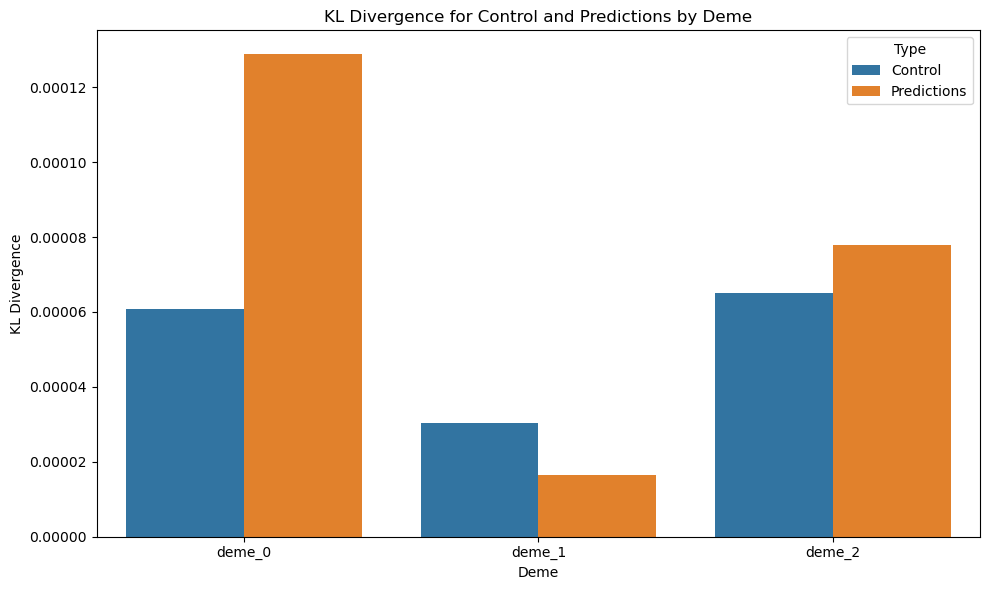

In [702]:
# Plot KL

KL_plots(samples, prediction, control, "3deme")

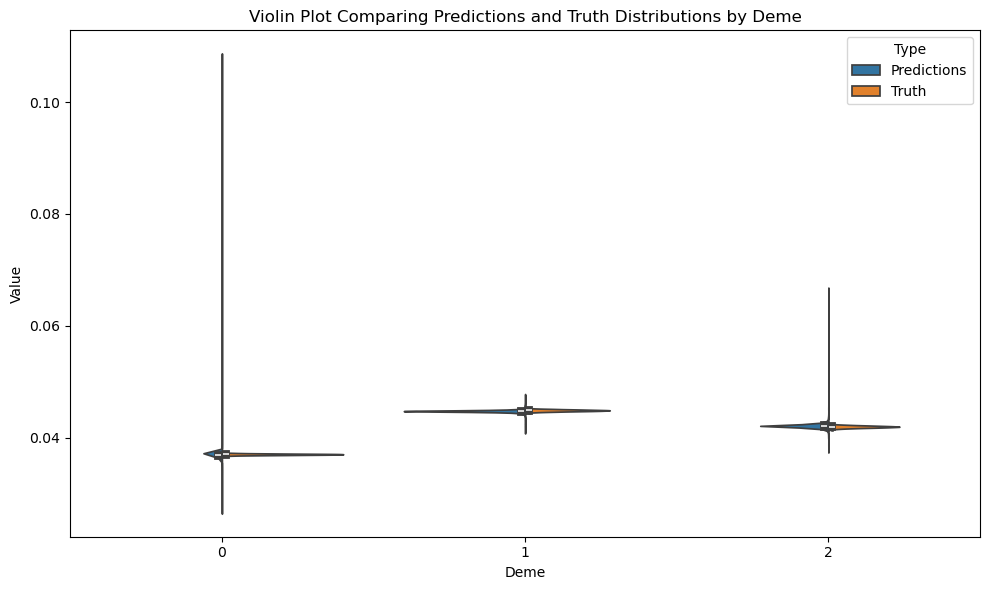

In [703]:
# Plot violin

violin_plots(samples, prediction, "3deme")

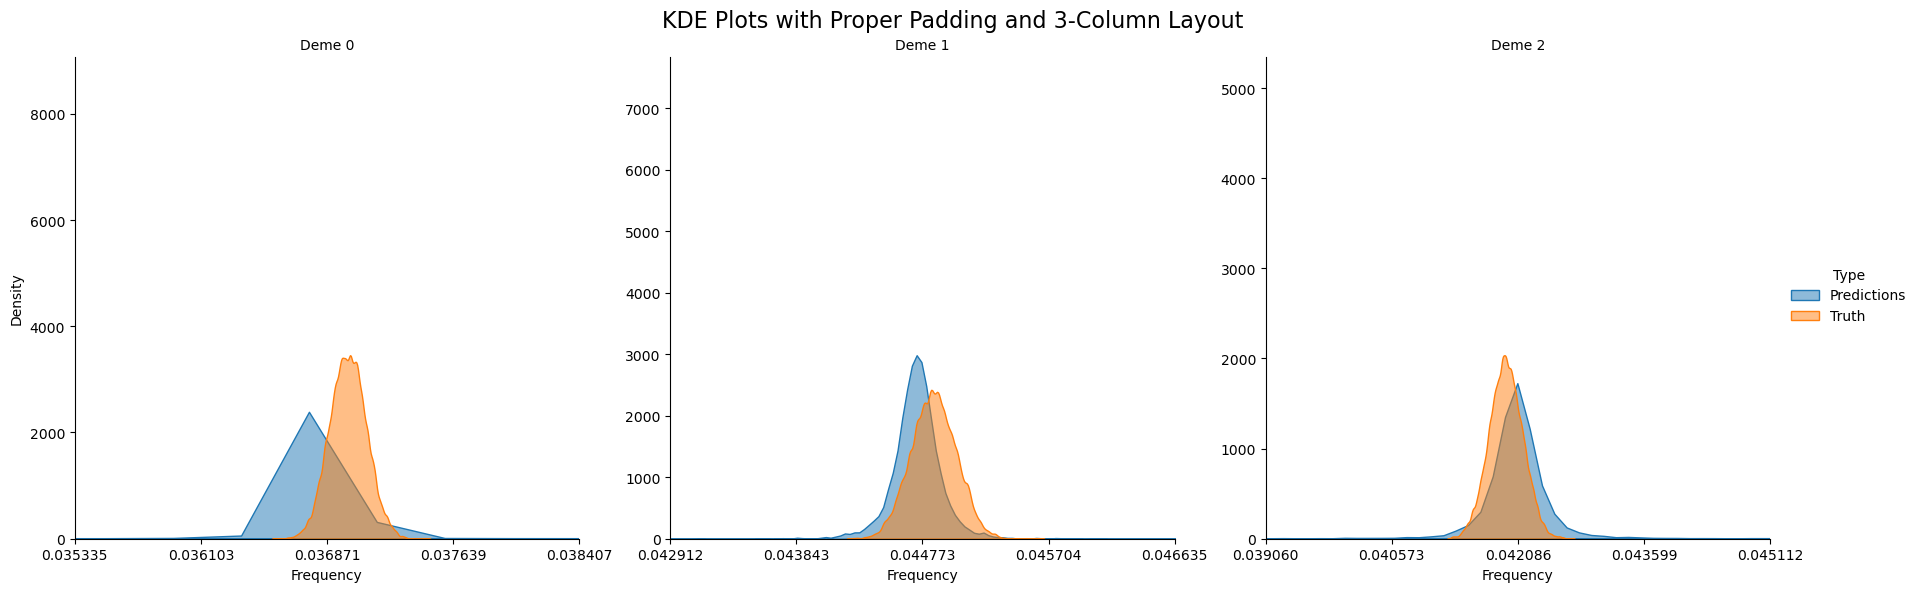

In [704]:
# Plot KDE

KDE_plots(samples, prediction, "3deme")

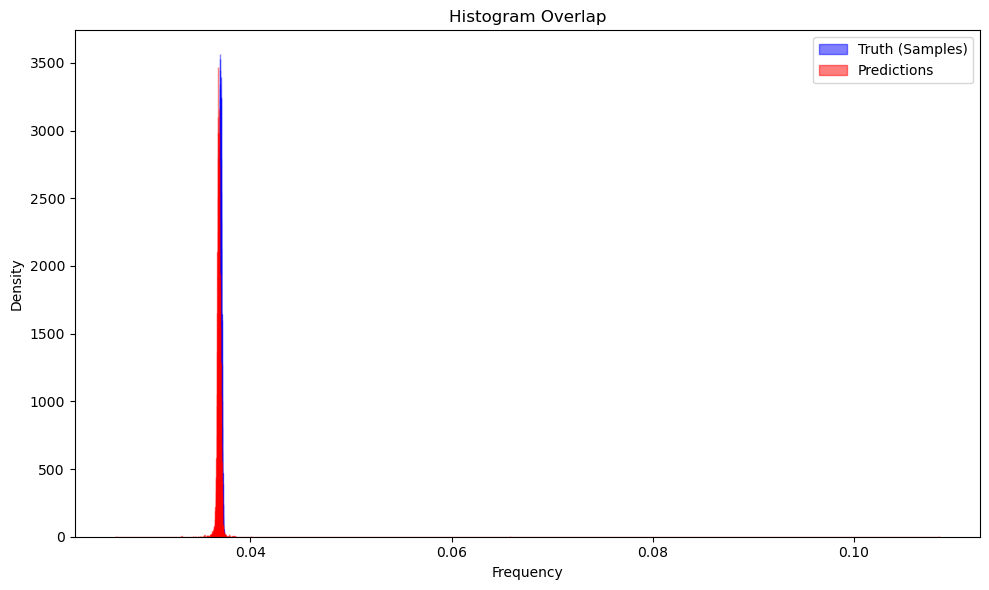

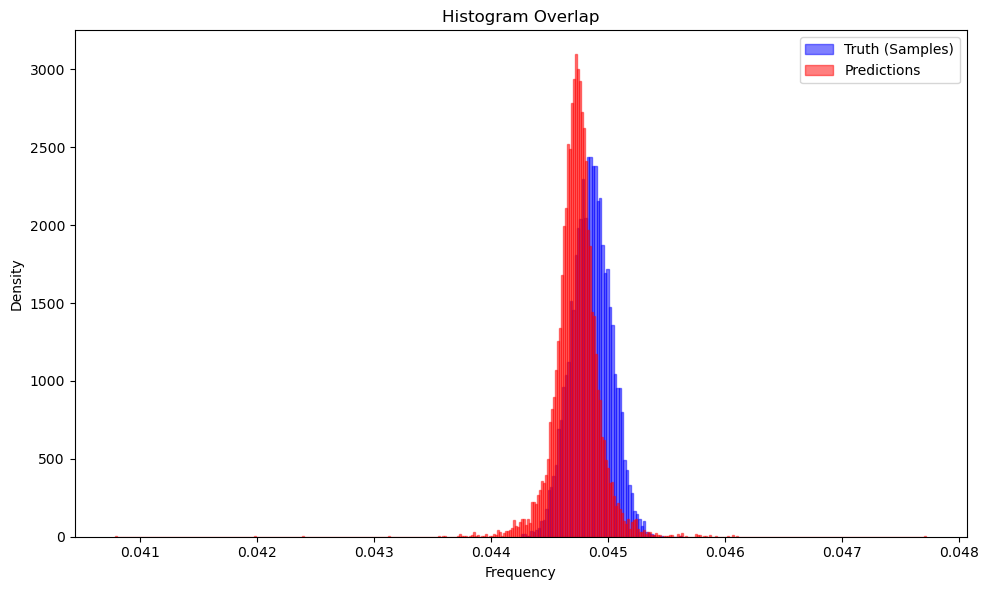

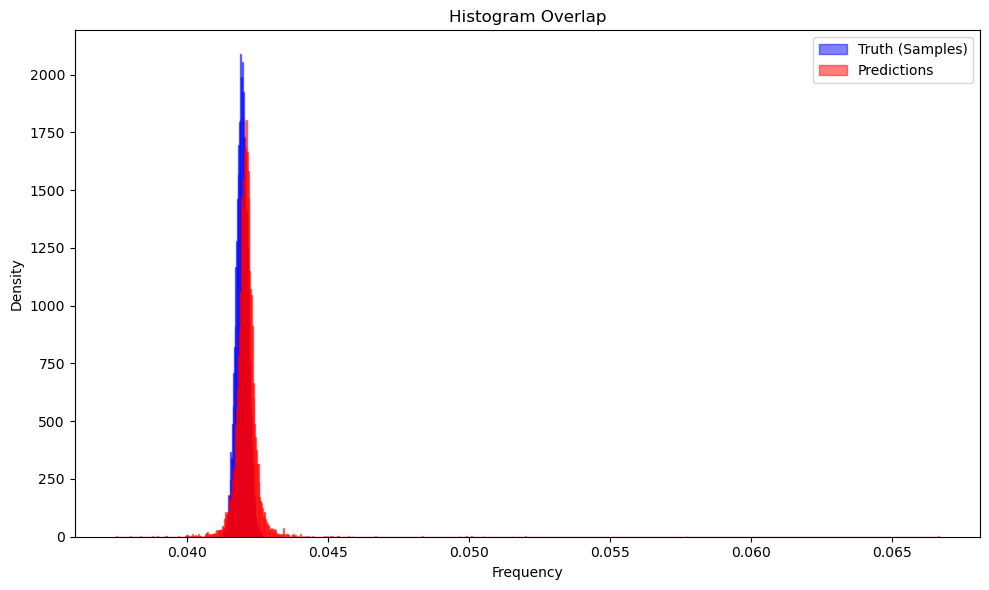

In [705]:
# Plot Histgram 

for i in range(len(samples)):
    histogram_overlap(samples[i], prediction[i], save_as = "3deme" , bins = 'auto')


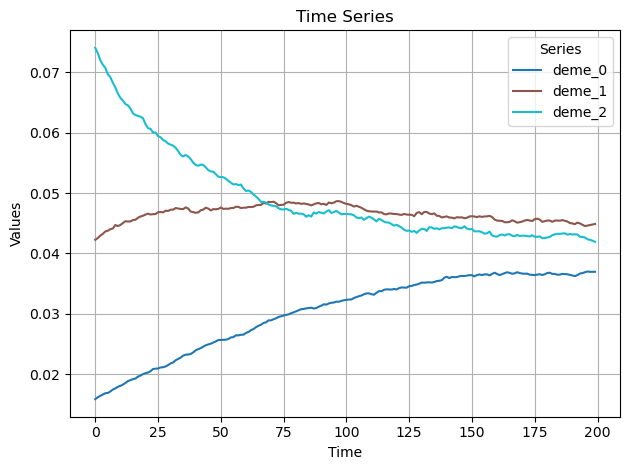

In [706]:
plot_time_series(data = series, save_as = "3deme")